## Classifying Tumour Transcriptome based on SNVs/INDELs

This is a tutorial to showcase how to use transcriptomic data to uncover cellular pathway modifications in presence of mutations in cancer-related genes. In this tutorial, the focus will be on TP53 tumour suppressor.

Here, it is assumed that data is already processed so that the feature matrix (x) has the samples in rows and gene names/ensembl ids in columns with log2(TPM+0.001) in matrix cells. Also, the label vector (y) is expected to have two columns, first with the same sample ids and the second with the mutational status of a gene of interest in each sample. For ease of access, a subset of TCGA data with 50 samples and 100 genes is stored in example_data directory which will be used in this notebook. The labels in label vector show the mutational status of TP53 gene in the samples.

In [1]:
# import required libraries
import pandas as pd
import numpy as np
import sklearn.metrics
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import StratifiedKFold, train_test_split, GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix

In [2]:
# read feature matrix (x) and label vector (y)
X = pd.read_csv('../example_data/X.tsv', delimiter = '\t', header=0, index_col=0)
y = pd.read_csv('../example_data/y.tsv', delimiter = '\t', header=0, index_col=0)

In [3]:
# convert y to Series instead of DF by extracting label column
y = pd.Series(y.mut_status)

Before performing classification, the best hyperparameters for the task should be identified. To do so, first 10% of the data will be put aside for final testing and 5-fold cross validation will be conducted on the 90% of the remaining data.

In [4]:
# put 10% of data aside for final check
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.1)

# set parameters
clf = RandomForestClassifier()
n_jobs = 40
n_splits = 5
param_space = {
    'n_estimators': [25, 50, 100, 200],
    'max_samples': [0.2, 0.4, 0.6, 0.8, 0.99],
    'max_features': ['sqrt', 0.01, 0.03, 0.05],
    'max_depth': [10, 50, 100, 200],
    'min_samples_split': [2, 10, 25, 50],
    'min_samples_leaf': [1, 2, 10, 50]
}

In [5]:
# function to find the best hyperparameters using f1-score
def findHyperparam(X, y):
    grid = GridSearchCV(estimator=clf, param_grid=param_space, scoring='f1_macro', n_jobs=n_jobs, 
                        cv=StratifiedKFold(n_splits=n_splits, shuffle=True))

    grid_result = grid.fit(X, y)
    return grid_result

# run the above function to find best hyperparameters
grid_result = findHyperparam(X_train, y_train)

In [6]:
# extract the best values found for tested hyperparameters
best_n_estimators = grid_result.best_params_.get('n_estimators')
best_max_depth = grid_result.best_params_.get('max_depth')
best_max_features = grid_result.best_params_.get('max_features')
best_max_samples = grid_result.best_params_.get('max_samples')
best_min_samples_leaf = grid_result.best_params_.get('min_samples_leaf')
best_min_samples_split = grid_result.best_params_.get('min_samples_split')

Now, the obtained hyperparameters should be tested on the held-out data:

In [7]:
# train the model on 90% of samples with the best hyperparameters
clf = RandomForestClassifier(n_estimators=best_n_estimators, max_depth=best_max_depth,
                             max_features=best_max_features, max_samples=best_max_samples, 
                             min_samples_leaf=best_min_samples_leaf, min_samples_split=best_min_samples_split, n_jobs=40)
clf.fit(X_train, y_train)

print(clf.score(X_train, y_train))

1.0


In [8]:
# test the performance on 10% of samples that were put aside at the beginning
sample_ids = X_test.index.values
rf_predictions = clf.predict(X_test)
rf_pred_df = pd.DataFrame({'p_id':sample_ids, 'status':y_test, 'predict':rf_predictions})

print(classification_report(rf_pred_df.status, rf_pred_df.predict))

              precision    recall  f1-score   support

         mut       0.33      0.50      0.40         2
          wt       0.50      0.33      0.40         3

    accuracy                           0.40         5
   macro avg       0.42      0.42      0.40         5
weighted avg       0.43      0.40      0.40         5



The performance is usually a bit worse on the validation set as the model has never seen this data. However, the difference between the two should not be very high. Here, the high difference is due to the very small sample size being used for training purposes only.

### Performance on all training examples

After confirming hyperparameter values, all samples can be used in a 5-fold cross validation analysis to assess the performance of the model on the whole training set.

In [9]:
skf = StratifiedKFold(n_splits=5, shuffle=True)

clf = RandomForestClassifier(n_estimators=3000, max_depth=best_max_depth, max_features=best_max_features, 
                             max_samples=best_max_samples, min_samples_split=best_min_samples_split, 
                             min_samples_leaf=best_min_samples_leaf)

In [10]:
# function to perform 5-fold CV using the given the model, X and y
def test_performance_5_fold_CV(clf, skf, X, y):
    
    all_pred_df = pd.DataFrame({'p_id':['a'], 'status':['mut_wt'], 'predict':['mut_wt']})
    all_prob = []
    true_label_prob = np.empty([0,])
    
    # test in 5-fold CV
    for train_index, test_index in skf.split(X, y):

        y_train, y_test = y.iloc[train_index], y.iloc[test_index]
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]

        # train on 80% of data
        clf.fit(X_train, y_train)

        # test on 20% of data
        sample_ids = X_test.index.values

        rf_predictions = clf.predict(X_test)
        rf_pred_df = pd.DataFrame({'p_id':sample_ids, 'status':y_test, 'predict':rf_predictions})
        all_pred_df = pd.concat([all_pred_df, rf_pred_df], axis=0)

        # extract prediction probabilities
        tcga_pog_prob = clf.predict_proba(X_test)
        for i in tcga_pog_prob:
            rf_prob=max(i)
            all_prob.append(rf_prob)
    
        if clf.classes_[0]=="wt":
            true_prob = tcga_pog_prob[:,0]
        else:
            true_prob = tcga_pog_prob[:, 1]
        true_label_prob = np.concatenate((true_label_prob, true_prob), axis=0)
    
    all_pred_df = all_pred_df[all_pred_df.p_id != 'a']
    
    return all_pred_df, all_prob, true_label_prob

# function to make AUROC graph
def generate_auroc_curve(tru_stat, tru_lab_prob, pos):
    data_fpr, data_tpr, data_thresholds = sklearn.metrics.roc_curve(tru_stat, tru_lab_prob, pos_label="wt")
    data_fpr_tpr = pd.DataFrame({'fpr':data_fpr, 'tpr':data_tpr})
    sns.lineplot(data=data_fpr_tpr, x='fpr', y='tpr', ax=pos)
    pos.set(xlabel='False Positive Rate', ylabel='True Positive Rate')
    pos.plot([0, 1], [0, 1], color='black', ls='--')

# function to make AUPRC graph
def generate_auprc_curve(tru_stat, tru_lab_prob, pos):
    data_prcsn, data_rcll, data_thrshlds = sklearn.metrics.precision_recall_curve(tru_stat, tru_lab_prob, pos_label="wt")
    data_prcsn_rcll = pd.DataFrame({'prcsn':data_prcsn, 'rcll':data_rcll})
    sns.lineplot(data=data_prcsn_rcll, x='rcll', y='prcsn', ax=pos)
    pos.set(xlabel='Recall', ylabel='Precision')
    pos.plot([0, 1], [1, 0], color='black', ls='--')

In [11]:
all_pred_df, all_prob, true_label_prob = test_performance_5_fold_CV(clf, skf, X, y)

# assess performance
print(confusion_matrix(all_pred_df.status, all_pred_df.predict, labels=['mut','wt']))
print(classification_report(all_pred_df.status, all_pred_df.predict))

[[18  7]
 [ 6 19]]
              precision    recall  f1-score   support

         mut       0.75      0.72      0.73        25
          wt       0.73      0.76      0.75        25

    accuracy                           0.74        50
   macro avg       0.74      0.74      0.74        50
weighted avg       0.74      0.74      0.74        50



While the confusion matrix shows the number of correctly and incorrectly predicted samples in each category, the classification report gives a summary of performance metrics. Additionally, AUROC and AUPRC graphs can be generated to further assess the performance.

Text(0.5, 0.6, 'AUPRC=0.71')

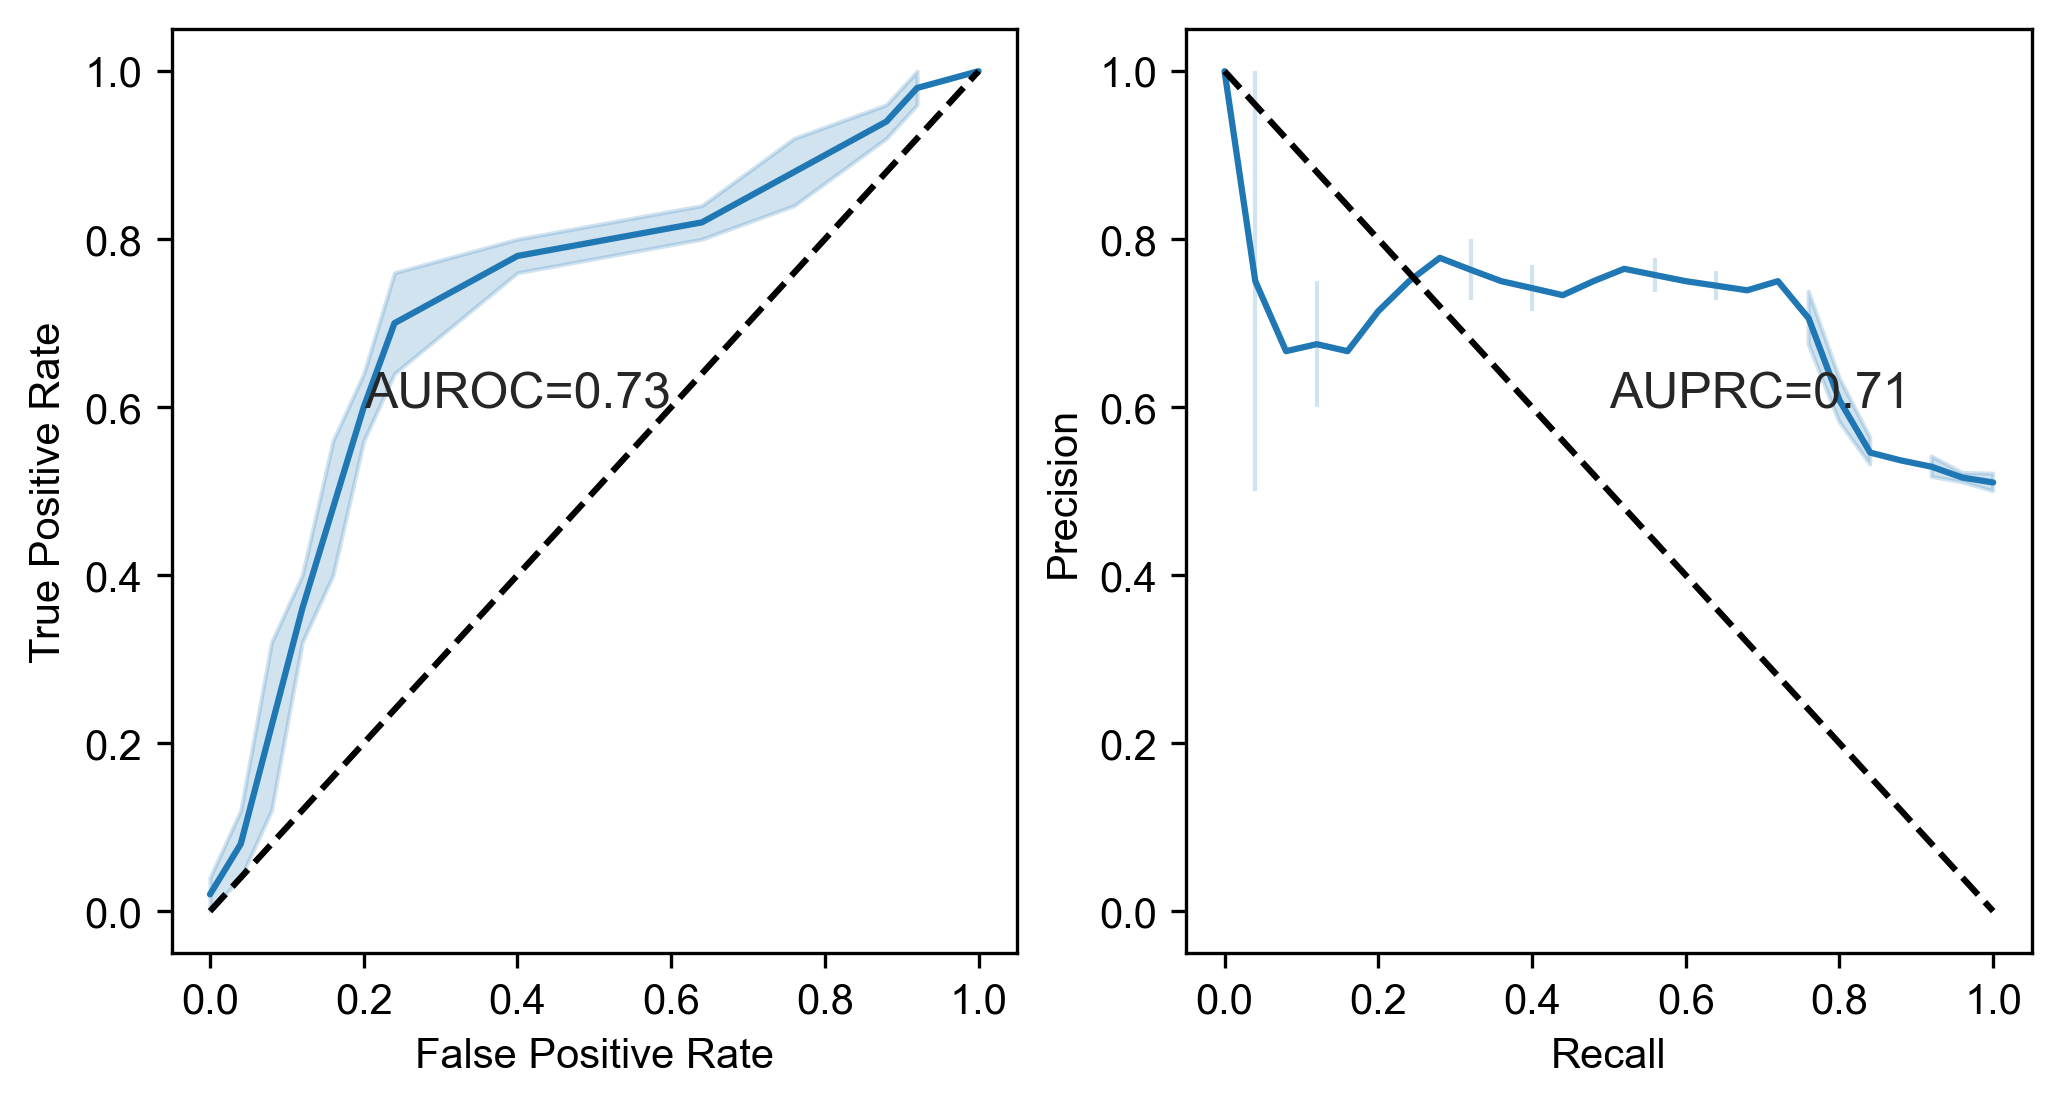

In [12]:
fig, axes =plt.subplots(1, 2, figsize=(8, 4), dpi=300)
sns.set_theme()
fnt_size = 18
generate_auroc_curve(all_pred_df.status, true_label_prob, axes[0])
generate_auprc_curve(all_pred_df.status, true_label_prob, axes[1])

auprc_val = sklearn.metrics.average_precision_score(all_pred_df.status, true_label_prob, pos_label="wt")
auroc_val = sklearn.metrics.roc_auc_score(all_pred_df.status, true_label_prob)

axes[0].text(0.20, 0.60, 'AUROC='+str(round(auroc_val, 2)))
axes[1].text(0.50, 0.60, 'AUPRC='+str(round(auprc_val, 2)))

The larger the area under these graphs, the better the model performance! As mentioned previously, the performance here is poor due to considerable low number of samples in the example set.